In [1]:
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.linalg import expm
from copy import deepcopy
import time
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pickle import load

2023-03-07 18:40:43.198436: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 18:40:43.286803: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-07 18:40:43.289639: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/user/.mujoco/mujoco200/bin:/home/user/.mujoco/mujoco200/bin
2023-03-07 18:40:43.289649:

In [2]:
def to_sequence(data, timesteps=1):
    n_features=data.shape[2]
    seq = []
    for i in range(len(data)-timesteps):
        # takes a window of data of specified timesteps
        temp = data[i:(i+timesteps)]
        temp = temp.reshape(timesteps, n_features)
        seq.append(temp)
        
    return np.array(seq)

In [3]:
df = pd.read_csv('./robotdatacollection_testing_50/ep1.csv')
model_path = './GoogleColab/Lstm_newModel_1'
feature_list = ['Fx','Fy','Fz','Mx','My']
TIMESTEP = 50
dt = 1/125
time_sec = 4
index_cut = int(time_sec/dt)

In [4]:
# cut first X seconds
df = df.drop(range(index_cut)).reset_index(drop=True)

one_occurace = np.where(df.Case == 1)[0]
print(one_occurace)

[2683 2684 2685 2686 2687 2688 2689 2690 2691 2692 2693 2694 2695 2696
 2697 2698 2699 2700 2701 2702 2703 2704 2705 2706 2707 2708 2709 2710
 2711 2712 2713 2714 2715 2716 2717 2718 2719 2720 2721 2722 2723 2724
 2725 2726 2727 2728 2729 2730 2731 2732 2733 2734 2735 2736 2737 2738
 2739 2741 2742 4221 4222 4223 4224 4225 4226 4227 4228 4229 4230 4231
 4232 4233 4234 4235 4236 4237 4238 4239 4240 4241 4242 4243 4244]


In [5]:
df_test = df[feature_list]

In [6]:
df_test.describe()

,Fx,Fy,Fz,Mx,My
count,4245.000000,4245.000000,4245.000000,4245.000000,4245.000000
mean,-0.149876,-0.313534,4.993887,0.027026,-0.013433
std,0.725089,0.778599,0.727104,0.070475,0.081749
min,-2.065007,-2.029141,0.797211,-0.107627,-0.177593
25%,-0.794075,-1.001396,4.635158,-0.036415,-0.087463
50%,-0.144463,-0.415420,4.996414,0.014450,-0.022233
75%,0.513213,0.405211,5.357661,0.094403,0.062349
max,1.357405,1.307601,8.705305,0.158249,0.168219


In [7]:
scaler = load(open('./GoogleColab/Normalizing.pkl', 'rb'))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [8]:
window = 30
df_test = df_test.rolling(window).mean()
# due to the moving average we the first (window-1) rows become NaN so we remove them
df_test = df_test.loc[window-1:]
print('Before Normalizing')
display(df_test.describe())
# apply normalization
# scale train data
names = df_test.columns
df_test[names] = scaler.transform(df_test[names])
df_test_df = df_test
print('After Normalizing')
display(df_test.describe())

Before Normalizing


,Fx,Fy,Fz,Mx,My
count,4216.000000,4216.000000,4216.000000,4216.000000,4216.000000
mean,-0.146246,-0.315609,4.998314,0.026759,-0.013852
std,0.703062,0.754942,0.446152,0.069430,0.080714
min,-1.512335,-1.520051,2.925089,-0.090411,-0.142706
25%,-0.822005,-0.983746,4.767595,-0.036604,-0.090068
50%,-0.112596,-0.434701,4.999366,0.014862,-0.024653
75%,0.558005,0.413657,5.234560,0.096136,0.063017
max,0.968618,1.127991,6.740875,0.145137,0.132565


After Normalizing


,Fx,Fy,Fz,Mx,My
count,4216.000000,4216.000000,4216.000000,4216.000000,4216.000000
mean,-0.027994,0.055760,-0.087458,0.115395,0.145690
std,0.232845,0.202625,0.079754,0.196683,0.211092
min,-0.480426,-0.267509,-0.458066,-0.216525,-0.191305
25%,-0.251798,-0.123567,-0.128701,-0.064101,-0.053639
50%,-0.016850,0.023796,-0.087270,0.081693,0.117442
75%,0.205245,0.251493,-0.045227,0.311927,0.346727
max,0.341235,0.443219,0.224040,0.450738,0.528618


In [9]:
df_test = np.expand_dims(df_test, axis=1)
print('Shape AFTER adding dimension:',df_test.shape)
x_test_seq= to_sequence(df_test, timesteps=TIMESTEP)
print(f"x_test = {x_test_seq.shape}")

Shape AFTER adding dimension: (4216, 1, 5)
x_test = (4166, 50, 5)


### 2. Loading Trained Model - stateless

In [10]:
model = keras.models.load_model(model_path)

2023-03-07 18:40:46.516249: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/user/.mujoco/mujoco200/bin:/home/user/.mujoco/mujoco200/bin
2023-03-07 18:40:46.516261: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-07 18:40:46.516272: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (linux-n8-room20): /proc/driver/nvidia/version does not exist
2023-03-07 18:40:46.516475: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the ap

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 5)]    0           []                               
                                                                                                  
 LSTM_1 (LSTM)                  (None, 50)           11200       ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 50)           0           ['LSTM_1[0][0]']                 
                                                                                                  
 lambda (Lambda)                (None, None, 50)     0           ['dropout[0][0]',                
                                                                  'input_1[0][0]']            

In [12]:
# model.get_weights()

### 3. Initialize test model (statefull)

In [13]:
def repeat(x_inp):
    x, inp = x_inp
    x = tf.expand_dims(x,1)
    x = tf.repeat(x, [tf.shape(inp)[1]],axis=1)
    return x

In [14]:
n_features = x_test_seq.shape[2]
predict_batch_size = 1

input_layer = keras.layers.Input(batch_shape=(predict_batch_size, None, n_features))

lstm1 = keras.layers.LSTM(units=50, activation='tanh', name='LSTM_1', 
                          return_sequences=False, stateful=True)(input_layer)

dropout1 = keras.layers.Dropout(0.2)(lstm1)

code = keras.layers.Lambda(repeat)([dropout1, input_layer])

lstm2 = keras.layers.LSTM(units=50, activation='tanh', name='LSTM_2', stateful=True,
                          return_sequences=True)(code)


dropout2 = keras.layers.Dropout(0.2)(lstm2)
out = keras.layers.TimeDistributed(keras.layers.Dense(units=n_features))(dropout2)

predict_model = keras.Model(input_layer, outputs=out)
predict_model.set_weights(model.get_weights())

### 4. Check cells

In [15]:
model.layers[1].states

ListWrapper([None, None])

In [16]:
predict_model.layers[1].states

ListWrapper([<tf.Variable 'LSTM_1/Variable:0' shape=(1, 50) dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]], dtype=float32)>, <tf.Variable 'LSTM_1/Variable:0' shape=(1, 50) dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]], dtype=float32)>])

### 5. Data Prep for online predictions

In [17]:
df_test_df.head()

,Fx,Fy,Fz,Mx,My
29,-0.384591,0.144024,-0.063872,0.195641,0.459980
30,-0.386247,0.141005,-0.061937,0.191775,0.460621
31,-0.389246,0.138126,-0.060151,0.187377,0.460956
32,-0.390572,0.134113,-0.060673,0.182951,0.461832
33,-0.392152,0.127479,-0.059387,0.178897,0.462415


In [18]:
# preprocessed data! 
fx = df_test_df.Fx.values
fy = df_test_df.Fy.values
fz = df_test_df.Fz.values
mx = df_test_df.Mx.values
my = df_test_df.My.values

duration = len(fx)
print(duration)

4216


### 6.1. Online Pred (stateful) -> `predict_model`

In [19]:
cnt = 0
statefull_pred = np.empty((0, 1, 5))

while cnt < duration: 
    features = [fx[cnt], fy[cnt], fz[cnt], mx[cnt],my[cnt]]
#     features_df = pd.DataFrame([features], columns=feature_list)
#     scaled_features = scaler.transform(features_df)

    x_test_single = np.reshape(features, (1, 1, 5))
    x_test_pred_stateful = predict_model.predict_on_batch(x_test_single)
    # append for plotting
    statefull_pred = np.concatenate((statefull_pred, x_test_pred_stateful), axis=0)

    cnt += 1

### 6.2. Online Pred (stateless) -> `model`

In [20]:
cnt = 0
stateless_pred = np.empty((0, 1, 5))

while cnt < duration: 
    features = [fx[cnt], fy[cnt], fz[cnt], mx[cnt],my[cnt]]
#     features_df = pd.DataFrame([features], columns=feature_list)
#     scaled_features = scaler.transform(features_df)

    x_test_single = np.reshape(features, (1, 1, 5))
    x_test_pred_stateless = model.predict_on_batch(x_test_single)
    # append for plotting
    stateless_pred = np.concatenate((stateless_pred, x_test_pred_stateless), axis=0)
    
    cnt += 1

In [21]:
# statefull
statefull_pred.shape

(4216, 1, 5)

In [22]:
#stateless
stateless_pred.shape

(4216, 1, 5)

In [23]:
model.layers[1].states

ListWrapper([None, None])

In [24]:
predict_model.layers[1].states

ListWrapper([<tf.Variable 'LSTM_1/Variable:0' shape=(1, 50) dtype=float32, numpy=
array([[-9.3888931e-02,  5.9922892e-03, -8.9382641e-02,  7.7174135e-02,
         4.2520769e-02,  1.3130042e-02,  6.4527325e-02,  7.5434409e-02,
         4.3398928e-02, -8.8602535e-02, -1.5508772e-01, -5.5977471e-02,
         2.1850236e-02, -1.6571039e-01,  1.2270199e-02, -3.4641173e-02,
         4.2109224e-03, -2.2006262e-02,  5.1880531e-02, -2.1222139e-02,
        -1.9945333e-02, -2.0999916e-02, -3.2504026e-02,  4.0913556e-02,
         3.4136095e-03, -1.5849310e-01, -3.8065419e-02,  9.6762091e-02,
        -9.7381322e-05, -2.3338284e-02, -8.9321390e-02,  2.9412208e-02,
         7.2075963e-02,  4.2647678e-02,  3.7463479e-02,  1.5879635e-02,
         1.2745284e-01,  7.7449217e-02,  9.8152772e-02, -9.6860684e-02,
        -1.2824480e-01,  4.9952887e-02,  3.4437997e-03,  4.5622122e-02,
         9.8818801e-03, -7.2028711e-02,  8.9015681e-03,  4.9885310e-02,
        -7.1933560e-02, -4.1570891e-02]], dtype=float3

### 6.3. Offline Pred (batch) - stateless

In [25]:
t_start = time.time()
x_test_pred_batch = model.predict(x_test_seq)
print('dt',time.time()-t_start)
print(x_test_seq.shape)
print(x_test_pred_batch.shape)

131/131 [==============================] - 2s 9ms/step
dt 1.9037411212921143
(4166, 50, 5)
(4166, 50, 5)


### 6.4. Online Pred (batch)

In [26]:
def append_vector(array, vector):
    # the buffer collects values from oldest on top, to newest on the bottom
    # Discard the oldest value which is value from the top of the list
    array.pop(0)
    # Add the new value to the bottom of the array
    array.insert(len(array), vector)

In [27]:
dur = len(fx)

In [28]:
memory = [[0] * len(feature_list) for _ in range(TIMESTEP)]
cnt = 0
online_batch = np.empty((0, 50, 5))
t_start = 0

while cnt < dur: 
    features = np.array([fx[cnt], fy[cnt], fz[cnt], mx[cnt],my[cnt]]).tolist()
    append_vector(memory, features)

#     # after 50 iterations (0-49) the memory buffer is filled and we can use it for predictions
#     # the buffer is structured = [F(0), F(1), F(2)...] and at each iteration the first row is discarded
#     # and new value is added to the end. Latest value at the end, oldest at the beginning.
    
    if cnt >= TIMESTEP-1: # memory buffer has filled up
        print('Loop at: ',cnt)
        memory_array = np.array(memory)
        x_test_batch = np.expand_dims(memory_array, axis=0)
        # obtain 3D input for the model
        print(x_test_batch.shape)
#         print(x_test)
        t_start = time.time()
        # make prediction using LSTM Autoencoder
        x_test_pred_loop_batch = model(x_test_batch)
        
        online_batch = np.concatenate((online_batch, x_test_pred_loop_batch), axis=0)
        print(online_batch.shape)
        print('dt',time.time()-t_start)

    cnt += 1

Loop at:  49
(1, 50, 5)
(1, 50, 5)
dt 0.05417203903198242
Loop at:  50
(1, 50, 5)
(2, 50, 5)
dt 0.029992103576660156
Loop at:  51
(1, 50, 5)
(3, 50, 5)
dt 0.02911996841430664
Loop at:  52
(1, 50, 5)
(4, 50, 5)
dt 0.02964019775390625
Loop at:  53
(1, 50, 5)
(5, 50, 5)
dt 0.030142545700073242
Loop at:  54
(1, 50, 5)
(6, 50, 5)
dt 0.029889583587646484
Loop at:  55
(1, 50, 5)
(7, 50, 5)
dt 0.02999591827392578
Loop at:  56
(1, 50, 5)
(8, 50, 5)
dt 0.029904603958129883
Loop at:  57
(1, 50, 5)
(9, 50, 5)
dt 0.030094385147094727
Loop at:  58
(1, 50, 5)
(10, 50, 5)
dt 0.0289156436920166
Loop at:  59
(1, 50, 5)
(11, 50, 5)
dt 0.029193639755249023
Loop at:  60
(1, 50, 5)
(12, 50, 5)
dt 0.028920888900756836
Loop at:  61
(1, 50, 5)
(13, 50, 5)
dt 0.02927875518798828
Loop at:  62
(1, 50, 5)
(14, 50, 5)
dt 0.030462980270385742
Loop at:  63
(1, 50, 5)
(15, 50, 5)
dt 0.03068828582763672
Loop at:  64
(1, 50, 5)
(16, 50, 5)
dt 0.030079364776611328
Loop at:  65
(1, 50, 5)
(17, 50, 5)
dt 0.0293054580688476

(139, 50, 5)
dt 0.02981257438659668
Loop at:  188
(1, 50, 5)
(140, 50, 5)
dt 0.029518842697143555
Loop at:  189
(1, 50, 5)
(141, 50, 5)
dt 0.04131436347961426
Loop at:  190
(1, 50, 5)
(142, 50, 5)
dt 0.09204506874084473
Loop at:  191
(1, 50, 5)
(143, 50, 5)
dt 0.09089994430541992
Loop at:  192
(1, 50, 5)
(144, 50, 5)
dt 0.09123635292053223
Loop at:  193
(1, 50, 5)
(145, 50, 5)
dt 0.09162235260009766
Loop at:  194
(1, 50, 5)
(146, 50, 5)
dt 0.09165000915527344
Loop at:  195
(1, 50, 5)
(147, 50, 5)
dt 0.09151268005371094
Loop at:  196
(1, 50, 5)
(148, 50, 5)
dt 0.09158992767333984
Loop at:  197
(1, 50, 5)
(149, 50, 5)
dt 0.09175682067871094
Loop at:  198
(1, 50, 5)
(150, 50, 5)
dt 0.09488773345947266
Loop at:  199
(1, 50, 5)
(151, 50, 5)
dt 0.09777474403381348
Loop at:  200
(1, 50, 5)
(152, 50, 5)
dt 0.06818056106567383
Loop at:  201
(1, 50, 5)
(153, 50, 5)
dt 0.03142523765563965
Loop at:  202
(1, 50, 5)
(154, 50, 5)
dt 0.03279447555541992
Loop at:  203
(1, 50, 5)
(155, 50, 5)
dt 0.03147

(273, 50, 5)
dt 0.030301332473754883
Loop at:  322
(1, 50, 5)
(274, 50, 5)
dt 0.029625892639160156
Loop at:  323
(1, 50, 5)
(275, 50, 5)
dt 0.03006744384765625
Loop at:  324
(1, 50, 5)
(276, 50, 5)
dt 0.030532360076904297
Loop at:  325
(1, 50, 5)
(277, 50, 5)
dt 0.02968573570251465
Loop at:  326
(1, 50, 5)
(278, 50, 5)
dt 0.030036449432373047
Loop at:  327
(1, 50, 5)
(279, 50, 5)
dt 0.029742002487182617
Loop at:  328
(1, 50, 5)
(280, 50, 5)
dt 0.030124902725219727
Loop at:  329
(1, 50, 5)
(281, 50, 5)
dt 0.029176712036132812
Loop at:  330
(1, 50, 5)
(282, 50, 5)
dt 0.029137849807739258
Loop at:  331
(1, 50, 5)
(283, 50, 5)
dt 0.030987977981567383
Loop at:  332
(1, 50, 5)
(284, 50, 5)
dt 0.03144502639770508
Loop at:  333
(1, 50, 5)
(285, 50, 5)
dt 0.030536413192749023
Loop at:  334
(1, 50, 5)
(286, 50, 5)
dt 0.02955913543701172
Loop at:  335
(1, 50, 5)
(287, 50, 5)
dt 0.030636072158813477
Loop at:  336
(1, 50, 5)
(288, 50, 5)
dt 0.030921459197998047
Loop at:  337
(1, 50, 5)
(289, 50, 5)

(406, 50, 5)
dt 0.029703140258789062
Loop at:  455
(1, 50, 5)
(407, 50, 5)
dt 0.0295870304107666
Loop at:  456
(1, 50, 5)
(408, 50, 5)
dt 0.0294950008392334
Loop at:  457
(1, 50, 5)
(409, 50, 5)
dt 0.029532194137573242
Loop at:  458
(1, 50, 5)
(410, 50, 5)
dt 0.02965545654296875
Loop at:  459
(1, 50, 5)
(411, 50, 5)
dt 0.029370784759521484
Loop at:  460
(1, 50, 5)
(412, 50, 5)
dt 0.029216527938842773
Loop at:  461
(1, 50, 5)
(413, 50, 5)
dt 0.029797792434692383
Loop at:  462
(1, 50, 5)
(414, 50, 5)
dt 0.02946925163269043
Loop at:  463
(1, 50, 5)
(415, 50, 5)
dt 0.029299259185791016
Loop at:  464
(1, 50, 5)
(416, 50, 5)
dt 0.029521465301513672
Loop at:  465
(1, 50, 5)
(417, 50, 5)
dt 0.030023813247680664
Loop at:  466
(1, 50, 5)
(418, 50, 5)
dt 0.029677629470825195
Loop at:  467
(1, 50, 5)
(419, 50, 5)
dt 0.029871463775634766
Loop at:  468
(1, 50, 5)
(420, 50, 5)
dt 0.029760360717773438
Loop at:  469
(1, 50, 5)
(421, 50, 5)
dt 0.02899789810180664
Loop at:  470
(1, 50, 5)
(422, 50, 5)
dt

(542, 50, 5)
dt 0.03509855270385742
Loop at:  591
(1, 50, 5)
(543, 50, 5)
dt 0.030484914779663086
Loop at:  592
(1, 50, 5)
(544, 50, 5)
dt 0.030958890914916992
Loop at:  593
(1, 50, 5)
(545, 50, 5)
dt 0.03003406524658203
Loop at:  594
(1, 50, 5)
(546, 50, 5)
dt 0.02994561195373535
Loop at:  595
(1, 50, 5)
(547, 50, 5)
dt 0.030306100845336914
Loop at:  596
(1, 50, 5)
(548, 50, 5)
dt 0.02978515625
Loop at:  597
(1, 50, 5)
(549, 50, 5)
dt 0.03055715560913086
Loop at:  598
(1, 50, 5)
(550, 50, 5)
dt 0.030333757400512695
Loop at:  599
(1, 50, 5)
(551, 50, 5)
dt 0.030490398406982422
Loop at:  600
(1, 50, 5)
(552, 50, 5)
dt 0.029572010040283203
Loop at:  601
(1, 50, 5)
(553, 50, 5)
dt 0.02964043617248535
Loop at:  602
(1, 50, 5)
(554, 50, 5)
dt 0.029861927032470703
Loop at:  603
(1, 50, 5)
(555, 50, 5)
dt 0.029462337493896484
Loop at:  604
(1, 50, 5)
(556, 50, 5)
dt 0.03142690658569336
Loop at:  605
(1, 50, 5)
(557, 50, 5)
dt 0.030711889266967773
Loop at:  606
(1, 50, 5)
(558, 50, 5)
dt 0.030

(677, 50, 5)
dt 0.030508756637573242
Loop at:  726
(1, 50, 5)
(678, 50, 5)
dt 0.030364036560058594
Loop at:  727
(1, 50, 5)
(679, 50, 5)
dt 0.030004262924194336
Loop at:  728
(1, 50, 5)
(680, 50, 5)
dt 0.029938697814941406
Loop at:  729
(1, 50, 5)
(681, 50, 5)
dt 0.03097248077392578
Loop at:  730
(1, 50, 5)
(682, 50, 5)
dt 0.03022480010986328
Loop at:  731
(1, 50, 5)
(683, 50, 5)
dt 0.02979302406311035
Loop at:  732
(1, 50, 5)
(684, 50, 5)
dt 0.030301809310913086
Loop at:  733
(1, 50, 5)
(685, 50, 5)
dt 0.02993631362915039
Loop at:  734
(1, 50, 5)
(686, 50, 5)
dt 0.029893159866333008
Loop at:  735
(1, 50, 5)
(687, 50, 5)
dt 0.02987194061279297
Loop at:  736
(1, 50, 5)
(688, 50, 5)
dt 0.030147790908813477
Loop at:  737
(1, 50, 5)
(689, 50, 5)
dt 0.02994823455810547
Loop at:  738
(1, 50, 5)
(690, 50, 5)
dt 0.02980351448059082
Loop at:  739
(1, 50, 5)
(691, 50, 5)
dt 0.030028343200683594
Loop at:  740
(1, 50, 5)
(692, 50, 5)
dt 0.02954888343811035
Loop at:  741
(1, 50, 5)
(693, 50, 5)
dt 

(811, 50, 5)
dt 0.029544353485107422
Loop at:  860
(1, 50, 5)
(812, 50, 5)
dt 0.02887725830078125
Loop at:  861
(1, 50, 5)
(813, 50, 5)
dt 0.02969646453857422
Loop at:  862
(1, 50, 5)
(814, 50, 5)
dt 0.029354095458984375
Loop at:  863
(1, 50, 5)
(815, 50, 5)
dt 0.02884984016418457
Loop at:  864
(1, 50, 5)
(816, 50, 5)
dt 0.029247045516967773
Loop at:  865
(1, 50, 5)
(817, 50, 5)
dt 0.02936387062072754
Loop at:  866
(1, 50, 5)
(818, 50, 5)
dt 0.030539512634277344
Loop at:  867
(1, 50, 5)
(819, 50, 5)
dt 0.02933502197265625
Loop at:  868
(1, 50, 5)
(820, 50, 5)
dt 0.029037952423095703
Loop at:  869
(1, 50, 5)
(821, 50, 5)
dt 0.02884650230407715
Loop at:  870
(1, 50, 5)
(822, 50, 5)
dt 0.029354095458984375
Loop at:  871
(1, 50, 5)
(823, 50, 5)
dt 0.029033899307250977
Loop at:  872
(1, 50, 5)
(824, 50, 5)
dt 0.029425382614135742
Loop at:  873
(1, 50, 5)
(825, 50, 5)
dt 0.029476165771484375
Loop at:  874
(1, 50, 5)
(826, 50, 5)
dt 0.029228925704956055
Loop at:  875
(1, 50, 5)
(827, 50, 5)
d

(949, 50, 5)
dt 0.03041815757751465
Loop at:  998
(1, 50, 5)
(950, 50, 5)
dt 0.03058147430419922
Loop at:  999
(1, 50, 5)
(951, 50, 5)
dt 0.02961564064025879
Loop at:  1000
(1, 50, 5)
(952, 50, 5)
dt 0.029114484786987305
Loop at:  1001
(1, 50, 5)
(953, 50, 5)
dt 0.029107093811035156
Loop at:  1002
(1, 50, 5)
(954, 50, 5)
dt 0.02921605110168457
Loop at:  1003
(1, 50, 5)
(955, 50, 5)
dt 0.028624773025512695
Loop at:  1004
(1, 50, 5)
(956, 50, 5)
dt 0.029606342315673828
Loop at:  1005
(1, 50, 5)
(957, 50, 5)
dt 0.028740644454956055
Loop at:  1006
(1, 50, 5)
(958, 50, 5)
dt 0.028593778610229492
Loop at:  1007
(1, 50, 5)
(959, 50, 5)
dt 0.02872920036315918
Loop at:  1008
(1, 50, 5)
(960, 50, 5)
dt 0.02845144271850586
Loop at:  1009
(1, 50, 5)
(961, 50, 5)
dt 0.028370141983032227
Loop at:  1010
(1, 50, 5)
(962, 50, 5)
dt 0.028748273849487305
Loop at:  1011
(1, 50, 5)
(963, 50, 5)
dt 0.028757810592651367
Loop at:  1012
(1, 50, 5)
(964, 50, 5)
dt 0.029442787170410156
Loop at:  1013
(1, 50, 5)


(1084, 50, 5)
dt 0.02968597412109375
Loop at:  1133
(1, 50, 5)
(1085, 50, 5)
dt 0.028822660446166992
Loop at:  1134
(1, 50, 5)
(1086, 50, 5)
dt 0.028533220291137695
Loop at:  1135
(1, 50, 5)
(1087, 50, 5)
dt 0.029192447662353516
Loop at:  1136
(1, 50, 5)
(1088, 50, 5)
dt 0.028870582580566406
Loop at:  1137
(1, 50, 5)
(1089, 50, 5)
dt 0.028798580169677734
Loop at:  1138
(1, 50, 5)
(1090, 50, 5)
dt 0.028394222259521484
Loop at:  1139
(1, 50, 5)
(1091, 50, 5)
dt 0.028341054916381836
Loop at:  1140
(1, 50, 5)
(1092, 50, 5)
dt 0.029491424560546875
Loop at:  1141
(1, 50, 5)
(1093, 50, 5)
dt 0.029227733612060547
Loop at:  1142
(1, 50, 5)
(1094, 50, 5)
dt 0.02834320068359375
Loop at:  1143
(1, 50, 5)
(1095, 50, 5)
dt 0.029093503952026367
Loop at:  1144
(1, 50, 5)
(1096, 50, 5)
dt 0.028790950775146484
Loop at:  1145
(1, 50, 5)
(1097, 50, 5)
dt 0.02907085418701172
Loop at:  1146
(1, 50, 5)
(1098, 50, 5)
dt 0.028980255126953125
Loop at:  1147
(1, 50, 5)
(1099, 50, 5)
dt 0.02960062026977539
Loop a

(1217, 50, 5)
dt 0.03154444694519043
Loop at:  1266
(1, 50, 5)
(1218, 50, 5)
dt 0.03076481819152832
Loop at:  1267
(1, 50, 5)
(1219, 50, 5)
dt 0.030135393142700195
Loop at:  1268
(1, 50, 5)
(1220, 50, 5)
dt 0.031015634536743164
Loop at:  1269
(1, 50, 5)
(1221, 50, 5)
dt 0.03128170967102051
Loop at:  1270
(1, 50, 5)
(1222, 50, 5)
dt 0.03011298179626465
Loop at:  1271
(1, 50, 5)
(1223, 50, 5)
dt 0.03013896942138672
Loop at:  1272
(1, 50, 5)
(1224, 50, 5)
dt 0.03094768524169922
Loop at:  1273
(1, 50, 5)
(1225, 50, 5)
dt 0.0316309928894043
Loop at:  1274
(1, 50, 5)
(1226, 50, 5)
dt 0.030925273895263672
Loop at:  1275
(1, 50, 5)
(1227, 50, 5)
dt 0.030008554458618164
Loop at:  1276
(1, 50, 5)
(1228, 50, 5)
dt 0.029349088668823242
Loop at:  1277
(1, 50, 5)
(1229, 50, 5)
dt 0.029597043991088867
Loop at:  1278
(1, 50, 5)
(1230, 50, 5)
dt 0.029698610305786133
Loop at:  1279
(1, 50, 5)
(1231, 50, 5)
dt 0.03090977668762207
Loop at:  1280
(1, 50, 5)
(1232, 50, 5)
dt 0.03975176811218262
Loop at:  12

(1350, 50, 5)
dt 0.029751300811767578
Loop at:  1399
(1, 50, 5)
(1351, 50, 5)
dt 0.029140710830688477
Loop at:  1400
(1, 50, 5)
(1352, 50, 5)
dt 0.029425859451293945
Loop at:  1401
(1, 50, 5)
(1353, 50, 5)
dt 0.029100894927978516
Loop at:  1402
(1, 50, 5)
(1354, 50, 5)
dt 0.029225587844848633
Loop at:  1403
(1, 50, 5)
(1355, 50, 5)
dt 0.028888702392578125
Loop at:  1404
(1, 50, 5)
(1356, 50, 5)
dt 0.029131174087524414
Loop at:  1405
(1, 50, 5)
(1357, 50, 5)
dt 0.02911686897277832
Loop at:  1406
(1, 50, 5)
(1358, 50, 5)
dt 0.029115676879882812
Loop at:  1407
(1, 50, 5)
(1359, 50, 5)
dt 0.028901338577270508
Loop at:  1408
(1, 50, 5)
(1360, 50, 5)
dt 0.029069185256958008
Loop at:  1409
(1, 50, 5)
(1361, 50, 5)
dt 0.029060840606689453
Loop at:  1410
(1, 50, 5)
(1362, 50, 5)
dt 0.029340028762817383
Loop at:  1411
(1, 50, 5)
(1363, 50, 5)
dt 0.02911543846130371
Loop at:  1412
(1, 50, 5)
(1364, 50, 5)
dt 0.029729127883911133
Loop at:  1413
(1, 50, 5)
(1365, 50, 5)
dt 0.029242277145385742
Loop

(1483, 50, 5)
dt 0.029935359954833984
Loop at:  1532
(1, 50, 5)
(1484, 50, 5)
dt 0.029484987258911133
Loop at:  1533
(1, 50, 5)
(1485, 50, 5)
dt 0.029323339462280273
Loop at:  1534
(1, 50, 5)
(1486, 50, 5)
dt 0.029350757598876953
Loop at:  1535
(1, 50, 5)
(1487, 50, 5)
dt 0.030951738357543945
Loop at:  1536
(1, 50, 5)
(1488, 50, 5)
dt 0.02957463264465332
Loop at:  1537
(1, 50, 5)
(1489, 50, 5)
dt 0.02934741973876953
Loop at:  1538
(1, 50, 5)
(1490, 50, 5)
dt 0.03018808364868164
Loop at:  1539
(1, 50, 5)
(1491, 50, 5)
dt 0.02964949607849121
Loop at:  1540
(1, 50, 5)
(1492, 50, 5)
dt 0.029417753219604492
Loop at:  1541
(1, 50, 5)
(1493, 50, 5)
dt 0.029478788375854492
Loop at:  1542
(1, 50, 5)
(1494, 50, 5)
dt 0.029139041900634766
Loop at:  1543
(1, 50, 5)
(1495, 50, 5)
dt 0.03002762794494629
Loop at:  1544
(1, 50, 5)
(1496, 50, 5)
dt 0.02961564064025879
Loop at:  1545
(1, 50, 5)
(1497, 50, 5)
dt 0.03107738494873047
Loop at:  1546
(1, 50, 5)
(1498, 50, 5)
dt 0.0918724536895752
Loop at:  1

(1615, 50, 5)
dt 0.029778718948364258
Loop at:  1664
(1, 50, 5)
(1616, 50, 5)
dt 0.028942584991455078
Loop at:  1665
(1, 50, 5)
(1617, 50, 5)
dt 0.029103755950927734
Loop at:  1666
(1, 50, 5)
(1618, 50, 5)
dt 0.02896881103515625
Loop at:  1667
(1, 50, 5)
(1619, 50, 5)
dt 0.029316425323486328
Loop at:  1668
(1, 50, 5)
(1620, 50, 5)
dt 0.028890132904052734
Loop at:  1669
(1, 50, 5)
(1621, 50, 5)
dt 0.02926158905029297
Loop at:  1670
(1, 50, 5)
(1622, 50, 5)
dt 0.030200958251953125
Loop at:  1671
(1, 50, 5)
(1623, 50, 5)
dt 0.030077695846557617
Loop at:  1672
(1, 50, 5)
(1624, 50, 5)
dt 0.02965068817138672
Loop at:  1673
(1, 50, 5)
(1625, 50, 5)
dt 0.02914905548095703
Loop at:  1674
(1, 50, 5)
(1626, 50, 5)
dt 0.029282808303833008
Loop at:  1675
(1, 50, 5)
(1627, 50, 5)
dt 0.029800891876220703
Loop at:  1676
(1, 50, 5)
(1628, 50, 5)
dt 0.029760360717773438
Loop at:  1677
(1, 50, 5)
(1629, 50, 5)
dt 0.03004765510559082
Loop at:  1678
(1, 50, 5)
(1630, 50, 5)
dt 0.02959918975830078
Loop at:

(1747, 50, 5)
dt 0.03133368492126465
Loop at:  1796
(1, 50, 5)
(1748, 50, 5)
dt 0.030339717864990234
Loop at:  1797
(1, 50, 5)
(1749, 50, 5)
dt 0.029223203659057617
Loop at:  1798
(1, 50, 5)
(1750, 50, 5)
dt 0.02944779396057129
Loop at:  1799
(1, 50, 5)
(1751, 50, 5)
dt 0.03013443946838379
Loop at:  1800
(1, 50, 5)
(1752, 50, 5)
dt 0.029893159866333008
Loop at:  1801
(1, 50, 5)
(1753, 50, 5)
dt 0.029432296752929688
Loop at:  1802
(1, 50, 5)
(1754, 50, 5)
dt 0.030254840850830078
Loop at:  1803
(1, 50, 5)
(1755, 50, 5)
dt 0.029977798461914062
Loop at:  1804
(1, 50, 5)
(1756, 50, 5)
dt 0.029779672622680664
Loop at:  1805
(1, 50, 5)
(1757, 50, 5)
dt 0.02971792221069336
Loop at:  1806
(1, 50, 5)
(1758, 50, 5)
dt 0.029529333114624023
Loop at:  1807
(1, 50, 5)
(1759, 50, 5)
dt 0.029237985610961914
Loop at:  1808
(1, 50, 5)
(1760, 50, 5)
dt 0.029546737670898438
Loop at:  1809
(1, 50, 5)
(1761, 50, 5)
dt 0.030403614044189453
Loop at:  1810
(1, 50, 5)
(1762, 50, 5)
dt 0.030076026916503906
Loop a

(1880, 50, 5)
dt 0.03199577331542969
Loop at:  1929
(1, 50, 5)
(1881, 50, 5)
dt 0.03127264976501465
Loop at:  1930
(1, 50, 5)
(1882, 50, 5)
dt 0.02919483184814453
Loop at:  1931
(1, 50, 5)
(1883, 50, 5)
dt 0.028861522674560547
Loop at:  1932
(1, 50, 5)
(1884, 50, 5)
dt 0.028366565704345703
Loop at:  1933
(1, 50, 5)
(1885, 50, 5)
dt 0.028272390365600586
Loop at:  1934
(1, 50, 5)
(1886, 50, 5)
dt 0.028605937957763672
Loop at:  1935
(1, 50, 5)
(1887, 50, 5)
dt 0.02995920181274414
Loop at:  1936
(1, 50, 5)
(1888, 50, 5)
dt 0.029922962188720703
Loop at:  1937
(1, 50, 5)
(1889, 50, 5)
dt 0.029253482818603516
Loop at:  1938
(1, 50, 5)
(1890, 50, 5)
dt 0.02925562858581543
Loop at:  1939
(1, 50, 5)
(1891, 50, 5)
dt 0.029972553253173828
Loop at:  1940
(1, 50, 5)
(1892, 50, 5)
dt 0.029763460159301758
Loop at:  1941
(1, 50, 5)
(1893, 50, 5)
dt 0.02991199493408203
Loop at:  1942
(1, 50, 5)
(1894, 50, 5)
dt 0.030447721481323242
Loop at:  1943
(1, 50, 5)
(1895, 50, 5)
dt 0.02978992462158203
Loop at: 

(2013, 50, 5)
dt 0.03039240837097168
Loop at:  2062
(1, 50, 5)
(2014, 50, 5)
dt 0.02952718734741211
Loop at:  2063
(1, 50, 5)
(2015, 50, 5)
dt 0.029769182205200195
Loop at:  2064
(1, 50, 5)
(2016, 50, 5)
dt 0.02971792221069336
Loop at:  2065
(1, 50, 5)
(2017, 50, 5)
dt 0.0303347110748291
Loop at:  2066
(1, 50, 5)
(2018, 50, 5)
dt 0.029308319091796875
Loop at:  2067
(1, 50, 5)
(2019, 50, 5)
dt 0.029663801193237305
Loop at:  2068
(1, 50, 5)
(2020, 50, 5)
dt 0.03014397621154785
Loop at:  2069
(1, 50, 5)
(2021, 50, 5)
dt 0.02970099449157715
Loop at:  2070
(1, 50, 5)
(2022, 50, 5)
dt 0.02984452247619629
Loop at:  2071
(1, 50, 5)
(2023, 50, 5)
dt 0.02935624122619629
Loop at:  2072
(1, 50, 5)
(2024, 50, 5)
dt 0.029874086380004883
Loop at:  2073
(1, 50, 5)
(2025, 50, 5)
dt 0.03026437759399414
Loop at:  2074
(1, 50, 5)
(2026, 50, 5)
dt 0.029800891876220703
Loop at:  2075
(1, 50, 5)
(2027, 50, 5)
dt 0.03050065040588379
Loop at:  2076
(1, 50, 5)
(2028, 50, 5)
dt 0.029692411422729492
Loop at:  207

(2146, 50, 5)
dt 0.03019547462463379
Loop at:  2195
(1, 50, 5)
(2147, 50, 5)
dt 0.030416488647460938
Loop at:  2196
(1, 50, 5)
(2148, 50, 5)
dt 0.030207395553588867
Loop at:  2197
(1, 50, 5)
(2149, 50, 5)
dt 0.030734539031982422
Loop at:  2198
(1, 50, 5)
(2150, 50, 5)
dt 0.02973008155822754
Loop at:  2199
(1, 50, 5)
(2151, 50, 5)
dt 0.030365467071533203
Loop at:  2200
(1, 50, 5)
(2152, 50, 5)
dt 0.03132009506225586
Loop at:  2201
(1, 50, 5)
(2153, 50, 5)
dt 0.03282666206359863
Loop at:  2202
(1, 50, 5)
(2154, 50, 5)
dt 0.029860496520996094
Loop at:  2203
(1, 50, 5)
(2155, 50, 5)
dt 0.0300900936126709
Loop at:  2204
(1, 50, 5)
(2156, 50, 5)
dt 0.0296480655670166
Loop at:  2205
(1, 50, 5)
(2157, 50, 5)
dt 0.030062198638916016
Loop at:  2206
(1, 50, 5)
(2158, 50, 5)
dt 0.029772043228149414
Loop at:  2207
(1, 50, 5)
(2159, 50, 5)
dt 0.03029179573059082
Loop at:  2208
(1, 50, 5)
(2160, 50, 5)
dt 0.029901981353759766
Loop at:  2209
(1, 50, 5)
(2161, 50, 5)
dt 0.031139612197875977
Loop at:  2

(2279, 50, 5)
dt 0.03226876258850098
Loop at:  2328
(1, 50, 5)
(2280, 50, 5)
dt 0.058576345443725586
Loop at:  2329
(1, 50, 5)
(2281, 50, 5)
dt 0.03046274185180664
Loop at:  2330
(1, 50, 5)
(2282, 50, 5)
dt 0.030716419219970703
Loop at:  2331
(1, 50, 5)
(2283, 50, 5)
dt 0.03052353858947754
Loop at:  2332
(1, 50, 5)
(2284, 50, 5)
dt 0.030069589614868164
Loop at:  2333
(1, 50, 5)
(2285, 50, 5)
dt 0.030926227569580078
Loop at:  2334
(1, 50, 5)
(2286, 50, 5)
dt 0.030947446823120117
Loop at:  2335
(1, 50, 5)
(2287, 50, 5)
dt 0.03076648712158203
Loop at:  2336
(1, 50, 5)
(2288, 50, 5)
dt 0.02991318702697754
Loop at:  2337
(1, 50, 5)
(2289, 50, 5)
dt 0.029820919036865234
Loop at:  2338
(1, 50, 5)
(2290, 50, 5)
dt 0.030388832092285156
Loop at:  2339
(1, 50, 5)
(2291, 50, 5)
dt 0.03053426742553711
Loop at:  2340
(1, 50, 5)
(2292, 50, 5)
dt 0.03121328353881836
Loop at:  2341
(1, 50, 5)
(2293, 50, 5)
dt 0.030113697052001953
Loop at:  2342
(1, 50, 5)
(2294, 50, 5)
dt 0.03026747703552246
Loop at:  

(2413, 50, 5)
dt 0.030710458755493164
Loop at:  2462
(1, 50, 5)
(2414, 50, 5)
dt 0.029665470123291016
Loop at:  2463
(1, 50, 5)
(2415, 50, 5)
dt 0.02938103675842285
Loop at:  2464
(1, 50, 5)
(2416, 50, 5)
dt 0.029900074005126953
Loop at:  2465
(1, 50, 5)
(2417, 50, 5)
dt 0.030379772186279297
Loop at:  2466
(1, 50, 5)
(2418, 50, 5)
dt 0.02936100959777832
Loop at:  2467
(1, 50, 5)
(2419, 50, 5)
dt 0.03027796745300293
Loop at:  2468
(1, 50, 5)
(2420, 50, 5)
dt 0.030370473861694336
Loop at:  2469
(1, 50, 5)
(2421, 50, 5)
dt 0.02979111671447754
Loop at:  2470
(1, 50, 5)
(2422, 50, 5)
dt 0.02900409698486328
Loop at:  2471
(1, 50, 5)
(2423, 50, 5)
dt 0.029435396194458008
Loop at:  2472
(1, 50, 5)
(2424, 50, 5)
dt 0.029591798782348633
Loop at:  2473
(1, 50, 5)
(2425, 50, 5)
dt 0.029445409774780273
Loop at:  2474
(1, 50, 5)
(2426, 50, 5)
dt 0.029198646545410156
Loop at:  2475
(1, 50, 5)
(2427, 50, 5)
dt 0.03046131134033203
Loop at:  2476
(1, 50, 5)
(2428, 50, 5)
dt 0.029236793518066406
Loop at:

(2546, 50, 5)
dt 0.03092217445373535
Loop at:  2595
(1, 50, 5)
(2547, 50, 5)
dt 0.030655384063720703
Loop at:  2596
(1, 50, 5)
(2548, 50, 5)
dt 0.030185699462890625
Loop at:  2597
(1, 50, 5)
(2549, 50, 5)
dt 0.030337095260620117
Loop at:  2598
(1, 50, 5)
(2550, 50, 5)
dt 0.030109643936157227
Loop at:  2599
(1, 50, 5)
(2551, 50, 5)
dt 0.030710697174072266
Loop at:  2600
(1, 50, 5)
(2552, 50, 5)
dt 0.030259132385253906
Loop at:  2601
(1, 50, 5)
(2553, 50, 5)
dt 0.030795574188232422
Loop at:  2602
(1, 50, 5)
(2554, 50, 5)
dt 0.030884265899658203
Loop at:  2603
(1, 50, 5)
(2555, 50, 5)
dt 0.03080439567565918
Loop at:  2604
(1, 50, 5)
(2556, 50, 5)
dt 0.03033447265625
Loop at:  2605
(1, 50, 5)
(2557, 50, 5)
dt 0.03000020980834961
Loop at:  2606
(1, 50, 5)
(2558, 50, 5)
dt 0.03025674819946289
Loop at:  2607
(1, 50, 5)
(2559, 50, 5)
dt 0.030220746994018555
Loop at:  2608
(1, 50, 5)
(2560, 50, 5)
dt 0.03175473213195801
Loop at:  2609
(1, 50, 5)
(2561, 50, 5)
dt 0.03137993812561035
Loop at:  26

(2680, 50, 5)
dt 0.030400991439819336
Loop at:  2729
(1, 50, 5)
(2681, 50, 5)
dt 0.030044078826904297
Loop at:  2730
(1, 50, 5)
(2682, 50, 5)
dt 0.029397964477539062
Loop at:  2731
(1, 50, 5)
(2683, 50, 5)
dt 0.030264854431152344
Loop at:  2732
(1, 50, 5)
(2684, 50, 5)
dt 0.029230594635009766
Loop at:  2733
(1, 50, 5)
(2685, 50, 5)
dt 0.030182361602783203
Loop at:  2734
(1, 50, 5)
(2686, 50, 5)
dt 0.028893709182739258
Loop at:  2735
(1, 50, 5)
(2687, 50, 5)
dt 0.030841588973999023
Loop at:  2736
(1, 50, 5)
(2688, 50, 5)
dt 0.02929854393005371
Loop at:  2737
(1, 50, 5)
(2689, 50, 5)
dt 0.030046939849853516
Loop at:  2738
(1, 50, 5)
(2690, 50, 5)
dt 0.030200958251953125
Loop at:  2739
(1, 50, 5)
(2691, 50, 5)
dt 0.030070066452026367
Loop at:  2740
(1, 50, 5)
(2692, 50, 5)
dt 0.02944183349609375
Loop at:  2741
(1, 50, 5)
(2693, 50, 5)
dt 0.029845476150512695
Loop at:  2742
(1, 50, 5)
(2694, 50, 5)
dt 0.031233549118041992
Loop at:  2743
(1, 50, 5)
(2695, 50, 5)
dt 0.030710697174072266
Loop

(2813, 50, 5)
dt 0.03209519386291504
Loop at:  2862
(1, 50, 5)
(2814, 50, 5)
dt 0.03081488609313965
Loop at:  2863
(1, 50, 5)
(2815, 50, 5)
dt 0.03089737892150879
Loop at:  2864
(1, 50, 5)
(2816, 50, 5)
dt 0.03189969062805176
Loop at:  2865
(1, 50, 5)
(2817, 50, 5)
dt 0.030100584030151367
Loop at:  2866
(1, 50, 5)
(2818, 50, 5)
dt 0.029939651489257812
Loop at:  2867
(1, 50, 5)
(2819, 50, 5)
dt 0.03069591522216797
Loop at:  2868
(1, 50, 5)
(2820, 50, 5)
dt 0.02996063232421875
Loop at:  2869
(1, 50, 5)
(2821, 50, 5)
dt 0.030518054962158203
Loop at:  2870
(1, 50, 5)
(2822, 50, 5)
dt 0.029619932174682617
Loop at:  2871
(1, 50, 5)
(2823, 50, 5)
dt 0.029772043228149414
Loop at:  2872
(1, 50, 5)
(2824, 50, 5)
dt 0.02986621856689453
Loop at:  2873
(1, 50, 5)
(2825, 50, 5)
dt 0.030070066452026367
Loop at:  2874
(1, 50, 5)
(2826, 50, 5)
dt 0.02926468849182129
Loop at:  2875
(1, 50, 5)
(2827, 50, 5)
dt 0.030745506286621094
Loop at:  2876
(1, 50, 5)
(2828, 50, 5)
dt 0.029726743698120117
Loop at:  

(2946, 50, 5)
dt 0.03125286102294922
Loop at:  2995
(1, 50, 5)
(2947, 50, 5)
dt 0.030423641204833984
Loop at:  2996
(1, 50, 5)
(2948, 50, 5)
dt 0.030422210693359375
Loop at:  2997
(1, 50, 5)
(2949, 50, 5)
dt 0.031279563903808594
Loop at:  2998
(1, 50, 5)
(2950, 50, 5)
dt 0.03072810173034668
Loop at:  2999
(1, 50, 5)
(2951, 50, 5)
dt 0.03026866912841797
Loop at:  3000
(1, 50, 5)
(2952, 50, 5)
dt 0.029611587524414062
Loop at:  3001
(1, 50, 5)
(2953, 50, 5)
dt 0.030411481857299805
Loop at:  3002
(1, 50, 5)
(2954, 50, 5)
dt 0.030737638473510742
Loop at:  3003
(1, 50, 5)
(2955, 50, 5)
dt 0.03052377700805664
Loop at:  3004
(1, 50, 5)
(2956, 50, 5)
dt 0.030270099639892578
Loop at:  3005
(1, 50, 5)
(2957, 50, 5)
dt 0.031418800354003906
Loop at:  3006
(1, 50, 5)
(2958, 50, 5)
dt 0.03182554244995117
Loop at:  3007
(1, 50, 5)
(2959, 50, 5)
dt 0.03129267692565918
Loop at:  3008
(1, 50, 5)
(2960, 50, 5)
dt 0.031662940979003906
Loop at:  3009
(1, 50, 5)
(2961, 50, 5)
dt 0.03162074089050293
Loop at: 

(3079, 50, 5)
dt 0.03252243995666504
Loop at:  3128
(1, 50, 5)
(3080, 50, 5)
dt 0.03128314018249512
Loop at:  3129
(1, 50, 5)
(3081, 50, 5)
dt 0.03200650215148926
Loop at:  3130
(1, 50, 5)
(3082, 50, 5)
dt 0.030193805694580078
Loop at:  3131
(1, 50, 5)
(3083, 50, 5)
dt 0.03185391426086426
Loop at:  3132
(1, 50, 5)
(3084, 50, 5)
dt 0.03066277503967285
Loop at:  3133
(1, 50, 5)
(3085, 50, 5)
dt 0.0311582088470459
Loop at:  3134
(1, 50, 5)
(3086, 50, 5)
dt 0.03090190887451172
Loop at:  3135
(1, 50, 5)
(3087, 50, 5)
dt 0.031743764877319336
Loop at:  3136
(1, 50, 5)
(3088, 50, 5)
dt 0.029921531677246094
Loop at:  3137
(1, 50, 5)
(3089, 50, 5)
dt 0.03064584732055664
Loop at:  3138
(1, 50, 5)
(3090, 50, 5)
dt 0.02972722053527832
Loop at:  3139
(1, 50, 5)
(3091, 50, 5)
dt 0.030199527740478516
Loop at:  3140
(1, 50, 5)
(3092, 50, 5)
dt 0.029323816299438477
Loop at:  3141
(1, 50, 5)
(3093, 50, 5)
dt 0.031163454055786133
Loop at:  3142
(1, 50, 5)
(3094, 50, 5)
dt 0.030055761337280273
Loop at:  31

(3212, 50, 5)
dt 0.030688047409057617
Loop at:  3261
(1, 50, 5)
(3213, 50, 5)
dt 0.03054952621459961
Loop at:  3262
(1, 50, 5)
(3214, 50, 5)
dt 0.030394792556762695
Loop at:  3263
(1, 50, 5)
(3215, 50, 5)
dt 0.0303802490234375
Loop at:  3264
(1, 50, 5)
(3216, 50, 5)
dt 0.030228376388549805
Loop at:  3265
(1, 50, 5)
(3217, 50, 5)
dt 0.030436038970947266
Loop at:  3266
(1, 50, 5)
(3218, 50, 5)
dt 0.03052544593811035
Loop at:  3267
(1, 50, 5)
(3219, 50, 5)
dt 0.03095388412475586
Loop at:  3268
(1, 50, 5)
(3220, 50, 5)
dt 0.03097844123840332
Loop at:  3269
(1, 50, 5)
(3221, 50, 5)
dt 0.03070998191833496
Loop at:  3270
(1, 50, 5)
(3222, 50, 5)
dt 0.031020164489746094
Loop at:  3271
(1, 50, 5)
(3223, 50, 5)
dt 0.0312039852142334
Loop at:  3272
(1, 50, 5)
(3224, 50, 5)
dt 0.03124856948852539
Loop at:  3273
(1, 50, 5)
(3225, 50, 5)
dt 0.03082585334777832
Loop at:  3274
(1, 50, 5)
(3226, 50, 5)
dt 0.03158926963806152
Loop at:  3275
(1, 50, 5)
(3227, 50, 5)
dt 0.030534982681274414
Loop at:  3276

(3345, 50, 5)
dt 0.03154730796813965
Loop at:  3394
(1, 50, 5)
(3346, 50, 5)
dt 0.030437469482421875
Loop at:  3395
(1, 50, 5)
(3347, 50, 5)
dt 0.030827045440673828
Loop at:  3396
(1, 50, 5)
(3348, 50, 5)
dt 0.030114412307739258
Loop at:  3397
(1, 50, 5)
(3349, 50, 5)
dt 0.030737876892089844
Loop at:  3398
(1, 50, 5)
(3350, 50, 5)
dt 0.029895782470703125
Loop at:  3399
(1, 50, 5)
(3351, 50, 5)
dt 0.030478715896606445
Loop at:  3400
(1, 50, 5)
(3352, 50, 5)
dt 0.048699140548706055
Loop at:  3401
(1, 50, 5)
(3353, 50, 5)
dt 0.031207561492919922
Loop at:  3402
(1, 50, 5)
(3354, 50, 5)
dt 0.029582977294921875
Loop at:  3403
(1, 50, 5)
(3355, 50, 5)
dt 0.030779361724853516
Loop at:  3404
(1, 50, 5)
(3356, 50, 5)
dt 0.029813289642333984
Loop at:  3405
(1, 50, 5)
(3357, 50, 5)
dt 0.030815839767456055
Loop at:  3406
(1, 50, 5)
(3358, 50, 5)
dt 0.029712915420532227
Loop at:  3407
(1, 50, 5)
(3359, 50, 5)
dt 0.04995846748352051
Loop at:  3408
(1, 50, 5)
(3360, 50, 5)
dt 0.031211137771606445
Loop

(3478, 50, 5)
dt 0.032041311264038086
Loop at:  3527
(1, 50, 5)
(3479, 50, 5)
dt 0.031016111373901367
Loop at:  3528
(1, 50, 5)
(3480, 50, 5)
dt 0.030263900756835938
Loop at:  3529
(1, 50, 5)
(3481, 50, 5)
dt 0.03065967559814453
Loop at:  3530
(1, 50, 5)
(3482, 50, 5)
dt 0.030443668365478516
Loop at:  3531
(1, 50, 5)
(3483, 50, 5)
dt 0.031023263931274414
Loop at:  3532
(1, 50, 5)
(3484, 50, 5)
dt 0.03037261962890625
Loop at:  3533
(1, 50, 5)
(3485, 50, 5)
dt 0.031848907470703125
Loop at:  3534
(1, 50, 5)
(3486, 50, 5)
dt 0.03115057945251465
Loop at:  3535
(1, 50, 5)
(3487, 50, 5)
dt 0.030686616897583008
Loop at:  3536
(1, 50, 5)
(3488, 50, 5)
dt 0.030407428741455078
Loop at:  3537
(1, 50, 5)
(3489, 50, 5)
dt 0.030484676361083984
Loop at:  3538
(1, 50, 5)
(3490, 50, 5)
dt 0.030776262283325195
Loop at:  3539
(1, 50, 5)
(3491, 50, 5)
dt 0.030709505081176758
Loop at:  3540
(1, 50, 5)
(3492, 50, 5)
dt 0.03160858154296875
Loop at:  3541
(1, 50, 5)
(3493, 50, 5)
dt 0.03088068962097168
Loop at

(3611, 50, 5)
dt 0.0314631462097168
Loop at:  3660
(1, 50, 5)
(3612, 50, 5)
dt 0.09135055541992188
Loop at:  3661
(1, 50, 5)
(3613, 50, 5)
dt 0.09292888641357422
Loop at:  3662
(1, 50, 5)
(3614, 50, 5)
dt 0.09376955032348633
Loop at:  3663
(1, 50, 5)
(3615, 50, 5)
dt 0.09401798248291016
Loop at:  3664
(1, 50, 5)
(3616, 50, 5)
dt 0.09242677688598633
Loop at:  3665
(1, 50, 5)
(3617, 50, 5)
dt 0.09476828575134277
Loop at:  3666
(1, 50, 5)
(3618, 50, 5)
dt 0.09227848052978516
Loop at:  3667
(1, 50, 5)
(3619, 50, 5)
dt 0.09348940849304199
Loop at:  3668
(1, 50, 5)
(3620, 50, 5)
dt 0.07317233085632324
Loop at:  3669
(1, 50, 5)
(3621, 50, 5)
dt 0.03430819511413574
Loop at:  3670
(1, 50, 5)
(3622, 50, 5)
dt 0.029520511627197266
Loop at:  3671
(1, 50, 5)
(3623, 50, 5)
dt 0.03097820281982422
Loop at:  3672
(1, 50, 5)
(3624, 50, 5)
dt 0.030602455139160156
Loop at:  3673
(1, 50, 5)
(3625, 50, 5)
dt 0.031013011932373047
Loop at:  3674
(1, 50, 5)
(3626, 50, 5)
dt 0.029654741287231445
Loop at:  3675


(3746, 50, 5)
dt 0.03134632110595703
Loop at:  3795
(1, 50, 5)
(3747, 50, 5)
dt 0.031105995178222656
Loop at:  3796
(1, 50, 5)
(3748, 50, 5)
dt 0.03075408935546875
Loop at:  3797
(1, 50, 5)
(3749, 50, 5)
dt 0.030924320220947266
Loop at:  3798
(1, 50, 5)
(3750, 50, 5)
dt 0.03122091293334961
Loop at:  3799
(1, 50, 5)
(3751, 50, 5)
dt 0.030718088150024414
Loop at:  3800
(1, 50, 5)
(3752, 50, 5)
dt 0.030930042266845703
Loop at:  3801
(1, 50, 5)
(3753, 50, 5)
dt 0.03130364418029785
Loop at:  3802
(1, 50, 5)
(3754, 50, 5)
dt 0.03133869171142578
Loop at:  3803
(1, 50, 5)
(3755, 50, 5)
dt 0.03083205223083496
Loop at:  3804
(1, 50, 5)
(3756, 50, 5)
dt 0.03106975555419922
Loop at:  3805
(1, 50, 5)
(3757, 50, 5)
dt 0.030757904052734375
Loop at:  3806
(1, 50, 5)
(3758, 50, 5)
dt 0.030163049697875977
Loop at:  3807
(1, 50, 5)
(3759, 50, 5)
dt 0.030679702758789062
Loop at:  3808
(1, 50, 5)
(3760, 50, 5)
dt 0.030122995376586914
Loop at:  3809
(1, 50, 5)
(3761, 50, 5)
dt 0.03114485740661621
Loop at:  

(3879, 50, 5)
dt 0.031078100204467773
Loop at:  3928
(1, 50, 5)
(3880, 50, 5)
dt 0.029595136642456055
Loop at:  3929
(1, 50, 5)
(3881, 50, 5)
dt 0.030783414840698242
Loop at:  3930
(1, 50, 5)
(3882, 50, 5)
dt 0.029608488082885742
Loop at:  3931
(1, 50, 5)
(3883, 50, 5)
dt 0.030631542205810547
Loop at:  3932
(1, 50, 5)
(3884, 50, 5)
dt 0.029651880264282227
Loop at:  3933
(1, 50, 5)
(3885, 50, 5)
dt 0.03071904182434082
Loop at:  3934
(1, 50, 5)
(3886, 50, 5)
dt 0.03145885467529297
Loop at:  3935
(1, 50, 5)
(3887, 50, 5)
dt 0.031557559967041016
Loop at:  3936
(1, 50, 5)
(3888, 50, 5)
dt 0.03133583068847656
Loop at:  3937
(1, 50, 5)
(3889, 50, 5)
dt 0.03096628189086914
Loop at:  3938
(1, 50, 5)
(3890, 50, 5)
dt 0.030840635299682617
Loop at:  3939
(1, 50, 5)
(3891, 50, 5)
dt 0.030950546264648438
Loop at:  3940
(1, 50, 5)
(3892, 50, 5)
dt 0.03175187110900879
Loop at:  3941
(1, 50, 5)
(3893, 50, 5)
dt 0.03152012825012207
Loop at:  3942
(1, 50, 5)
(3894, 50, 5)
dt 0.0309600830078125
Loop at:  

(4012, 50, 5)
dt 0.03104114532470703
Loop at:  4061
(1, 50, 5)
(4013, 50, 5)
dt 0.031049251556396484
Loop at:  4062
(1, 50, 5)
(4014, 50, 5)
dt 0.029736757278442383
Loop at:  4063
(1, 50, 5)
(4015, 50, 5)
dt 0.03075551986694336
Loop at:  4064
(1, 50, 5)
(4016, 50, 5)
dt 0.02935338020324707
Loop at:  4065
(1, 50, 5)
(4017, 50, 5)
dt 0.030907154083251953
Loop at:  4066
(1, 50, 5)
(4018, 50, 5)
dt 0.029737234115600586
Loop at:  4067
(1, 50, 5)
(4019, 50, 5)
dt 0.03178524971008301
Loop at:  4068
(1, 50, 5)
(4020, 50, 5)
dt 0.03022289276123047
Loop at:  4069
(1, 50, 5)
(4021, 50, 5)
dt 0.03080439567565918
Loop at:  4070
(1, 50, 5)
(4022, 50, 5)
dt 0.02976369857788086
Loop at:  4071
(1, 50, 5)
(4023, 50, 5)
dt 0.030887365341186523
Loop at:  4072
(1, 50, 5)
(4024, 50, 5)
dt 0.02994227409362793
Loop at:  4073
(1, 50, 5)
(4025, 50, 5)
dt 0.030799150466918945
Loop at:  4074
(1, 50, 5)
(4026, 50, 5)
dt 0.030434846878051758
Loop at:  4075
(1, 50, 5)
(4027, 50, 5)
dt 0.03107309341430664
Loop at:  4

(4145, 50, 5)
dt 0.030417203903198242
Loop at:  4194
(1, 50, 5)
(4146, 50, 5)
dt 0.030600786209106445
Loop at:  4195
(1, 50, 5)
(4147, 50, 5)
dt 0.03020930290222168
Loop at:  4196
(1, 50, 5)
(4148, 50, 5)
dt 0.029972076416015625
Loop at:  4197
(1, 50, 5)
(4149, 50, 5)
dt 0.029978036880493164
Loop at:  4198
(1, 50, 5)
(4150, 50, 5)
dt 0.03030681610107422
Loop at:  4199
(1, 50, 5)
(4151, 50, 5)
dt 0.030680179595947266
Loop at:  4200
(1, 50, 5)
(4152, 50, 5)
dt 0.03111410140991211
Loop at:  4201
(1, 50, 5)
(4153, 50, 5)
dt 0.03092169761657715
Loop at:  4202
(1, 50, 5)
(4154, 50, 5)
dt 0.0311429500579834
Loop at:  4203
(1, 50, 5)
(4155, 50, 5)
dt 0.03148508071899414
Loop at:  4204
(1, 50, 5)
(4156, 50, 5)
dt 0.0315401554107666
Loop at:  4205
(1, 50, 5)
(4157, 50, 5)
dt 0.03133058547973633
Loop at:  4206
(1, 50, 5)
(4158, 50, 5)
dt 0.031348228454589844
Loop at:  4207
(1, 50, 5)
(4159, 50, 5)
dt 0.031842708587646484
Loop at:  4208
(1, 50, 5)
(4160, 50, 5)
dt 0.03149008750915527
Loop at:  420

### 7. Plot
x_test_pred_batch = model.predict(x_test_seq)


In [29]:
# input sequence
x_test_seq.shape

(4166, 50, 5)

In [30]:
# batch reconstruct - offline
x_test_pred_batch.shape

(4166, 50, 5)

In [31]:
#batch reconstruct - online
online_batch.shape

(4167, 50, 5)

In [32]:
# statefull
statefull_pred.shape

(4216, 1, 5)

In [33]:
# stateless
stateless_pred.shape

(4216, 1, 5)

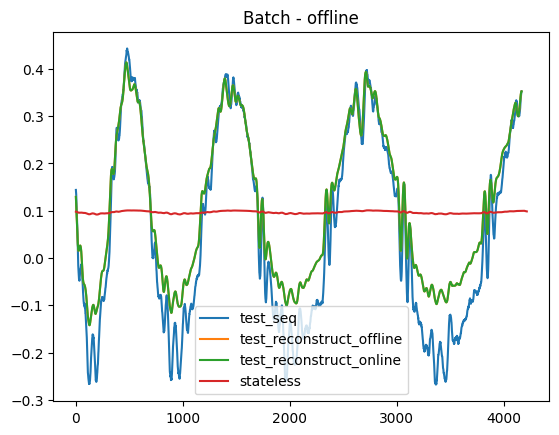

In [38]:
end = 4216
feat = 1
plt.title('Batch - offline')
plt.plot(x_test_seq[:end,0,feat],label='test_seq')
plt.plot(x_test_pred_batch[:end,0,feat],label='test_reconstruct_offline')
plt.plot(online_batch[:end,0,feat],label='test_reconstruct_online')
plt.plot(stateless_pred[:end,:,feat],label='stateless')
# plt.plot(statefull_pred[:end,:,feat], label='statefull')
plt.legend()
plt.show()

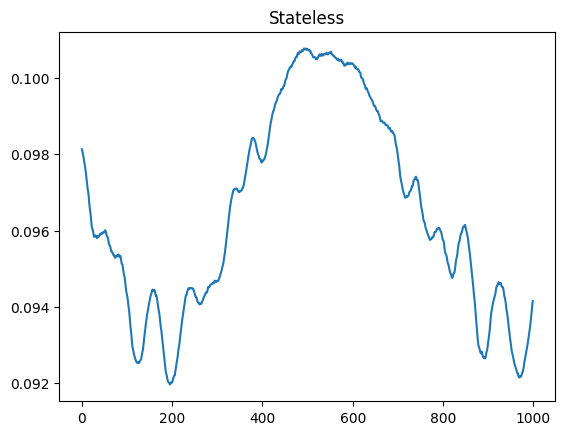

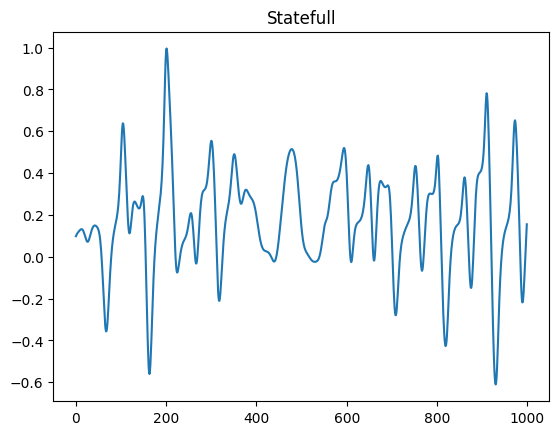

In [35]:
plt.figure()
plt.title('Stateless')
plt.plot(stateless_pred[:1000,:,1])
plt.show()

plt.figure()
plt.title('Statefull')
plt.plot(statefull_pred[:1000,:,1])
plt.show()

# plt.figure()
# plt.title('Real')
# plt.plot(df_test_df.Fy.loc[0:duration])


### Settings

In [ ]:
feature_list = ['Fx','Fy','Fz','Mx','My']
# feature_list = ['Fx','Fy']
TIMESTEP = 50

In [ ]:
ERROR_TOP = 0.0007
PEG_RADIUS = 0.0021
HOLE_RADIUS = 0.0024

cnt = 0
robot = False

### 1. Test set - data preperation

In [ ]:
dt = 1/125
time_sec = 4
index_cut = int(time_sec/dt)
print(index_cut)
# verify that we cut appropiately to 4 sec of data from start
print(df_test_original.t.iloc[index_cut]-df_test_original.t.iloc[0])
# cut the first X sec
df_test_original = df_test_original.drop(range(index_cut)).reset_index(drop=True)


one_occurace = np.where(df_test_original.Case == 1)[0]
print(one_occurace)

#### Chosing appropiate features, reshaping and changing to 3D form for LSTM

In [ ]:
df_test = df_test_original[feature_list]
print('Training shape before adding dimension:',df_test.shape)
if scale:
    scaler = load(open('./scaler/MinMaxScaler.pkl', 'rb'))
    window = 30
    df_test = df_test.rolling(window).mean()
    df_test = scaler.transform(df_test)

df_test = np.expand_dims(df_test, axis=1)
df_test_seq = to_sequence(df_test, timesteps=TIMESTEP)
print('Sequence shape: ',df_test_seq.shape)

In [ ]:
def append_vector(array, vector):
    # the buffer collects values from oldest on top, to newest on the bottom
    # Discard the oldest value which is value from the top of the list
    array.pop(0)
    # Add the new value to the bottom of the array
    array.insert(len(array), vector)

In [ ]:
# unpacking values from DataFrame
fx = df_test_original.Fx.values
fy = df_test_original.Fy.values
fz = df_test_original.Fz.values
mx = df_test_original.Mx.values
my = df_test_original.My.values

In [ ]:
df_test_original.Fx

### 1. Predict all values at once (batch_size=len(data))

In [ ]:
t_start = time.time()
x_test_pred_batch = model(df_test_seq)
print('dt',time.time()-t_start)
print(x_test_pred_batch.shape)

### 2. Online prediction but with `timestep = 50` (collect buffer) 

In [ ]:
memory = [[0] * len(feature_list) for _ in range(TIMESTEP)]

cnt = 0
anomalies_list = []
anom_idx_list = []
t_start=0

while cnt < 50: 
    features = np.array([fx[cnt], fy[cnt], fz[cnt], mx[cnt],my[cnt]]).tolist()
    append_vector(memory, features)

#     # after 50 iterations (0-49) the memory buffer is filled and we can use it for predictions
#     # the buffer is structured = [F(0), F(1), F(2)...] and at each iteration the first row is discarded
#     # and new value is added to the end. Latest value at the end, oldest at the beginning.
    
    if cnt >= TIMESTEP-1: # memory buffer has filled up
        print('Loop at: ',cnt)
        memory_array = np.array(memory)
        x_test = np.expand_dims(memory_array, axis=0)
        # obtain 3D input for the model
        print(x_test.shape)
#         print(x_test)
        t_start = time.time()
        # make prediction using LSTM Autoencoder
        x_test_pred_loop_batch = model(x_test)
        print('dt',time.time()-t_start)

    cnt += 1

In [ ]:
x_test_pred_loop_batch.shape

In [ ]:
feat = 1
plt.plot(df_test_seq[0][:,feat], label = 'Real Test Signal')
plt.plot(x_test_pred_loop_batch[0][:,feat], label='Batch Loop pred')
plt.plot(x_test_pred_batch[0][:,feat], label='Batch pred')
plt.legend()
plt.show()

### 3 & 4. Online prediction but with `timestep = 1` no buffer -> stateful network and stateless!

1. We trained an LSTM autoencoder called `model` which contains also weights (statelsess) 
2. Now we initialize network with same architecture but for testing which is statefull + it takes the models weights

In [ ]:
model.summary()

In [ ]:
def repeat(x_inp):
    x, inp = x_inp
    x = tf.expand_dims(x,1)
    x = tf.repeat(x, [tf.shape(inp)[1]],axis=1)
    return x


n_features = 5
predict_batch_size = 1

# encoder
input_layer = keras.layers.Input(batch_shape=(predict_batch_size, None, n_features), name='Encoder_Input')

conv1 = keras.layers.Conv1D(filters=32, kernel_size=15, padding='same', 
                            data_format='channels_last',dilation_rate=1, 
                            activation="linear", name='Encoder_Conv')(input_layer)

lstm1 = keras.layers.LSTM(units=50, activation='tanh', name='Encoder_LSTM', 
                          return_sequences=False, stateful=True)(conv1)

dropout1 = keras.layers.Dropout(0.2, name='Encoder_Dropout')(lstm1)

# dimension fix layer
repeat = keras.layers.Lambda(repeat)([dropout1, input_layer])

# decoder
lstm2 = keras.layers.LSTM(units=50, activation='tanh', name='Decoder_LSTM', 
                          return_sequences=True, stateful=True)(repeat)

conv2 = keras.layers.Conv1D(filters=32, kernel_size=15, padding='same', 
                            data_format='channels_last',dilation_rate=1, 
                            activation="linear",name='Decoder_Conv')(lstm2)

dropout2 = keras.layers.Dropout(0.2, name='Decoder_Dropout')(conv2)
out = keras.layers.TimeDistributed(keras.layers.Dense(units=n_features), name='Output_Layer')(dropout2)


predict_model = keras.Model(input_layer, outputs=out)


In [ ]:
# predict_model.summary()

In [ ]:
predict_model.set_weights(model.get_weights())

In [ ]:
model.layers[2].name

In [ ]:
model.layers[2].states

In [ ]:
model.layers[5].states

In [ ]:
# hidden state / cell state
predict_model.layers[2].states

In [ ]:
predict_model.layers[5].states

In [ ]:
duration = len(fx)

### Statefull

In [ ]:
stateful = True

cnt = 0
t_start=0
x_test_single_preds_list_stateful = []

while cnt < duration: 
    features = np.array([fx[cnt], fy[cnt], fz[cnt], mx[cnt],my[cnt]])

    x_test_single = np.reshape(features, (1, 1, len(features)))
    
    x_test_pred_single = predict_model.predict_on_batch(x_test_single)
    x_test_single_preds_list_stateful.append(x_test_pred_single.flatten())

    cnt += 1

### Stateless

In [ ]:
stateful = False

cnt = 0
t_start=0
x_test_single_preds_list_stateless = []

while cnt < duration: 
    features = np.array([fx[cnt], fy[cnt], fz[cnt], mx[cnt],my[cnt]])

    x_test_single = np.reshape(features, (1, 1, len(features)))
    
    x_test_pred_single = model.predict_on_batch(x_test_single)
    x_test_single_preds_list_stateless.append(x_test_pred_single.flatten())

    cnt += 1

#### Comparison

In [ ]:
predict_model.layers[2].states

In [ ]:
model.layers[2].states

In [ ]:
plt.title('Plot for sample prediction with stateful=False')
plt.plot(np.array(x_test_single_preds_list_stateless)[:,1])
plt.show()

In [ ]:
plt.title('Plot for sample prediction with stateful=True')
plt.plot(np.array(x_test_single_preds_list_stateful)[:,1])
plt.show()

In [ ]:
plt.title('Plot real test data we try to reconstruct')
plt.plot(df_test[:,:,1])
plt.show()

#### More analysis

In [ ]:
from sklearn.linear_model import LinearRegression
stateless = np.array(x_test_single_preds_list_stateless)[:,2]
stateful = np.array(x_test_single_preds_list_stateful)[:,2]
real = df_test[:,:,1].flatten()


In [ ]:
plt.scatter(stateless, real)
plt.xlabel('Stateless')
plt.ylabel('Real')
plt.grid()
plt.show()

In [ ]:
x = stateless.reshape(-1, 1)
y = real.reshape(-1, 1)
print(x.shape)
print(y.shape)

In [ ]:
reg = LinearRegression().fit(x, y)

In [ ]:
print(reg.coef_[0][0])
print(reg.intercept_[0])
a = reg.coef_[0][0]
b = reg.intercept_[0]

# feature : 
# a = 200.4764
# b = 0.78652936

Feature 0: 
a = -169.42653
b = -46.16128 <br> 
feature 1: 
a = 200.4764
b = 0.78652936 <br>


In [ ]:
plt.scatter(stateless, real)
plt.xlabel('Stateless')
plt.plot(x, a*x+b, color='r')
plt.ylabel('Real')
plt.grid()
plt.show()

In [ ]:
plt.figure()
plt.plot(a*stateless+b,label='stateless')
plt.plot(real, label='real')
plt.legend()
plt.show()

## Comparison 

In [ ]:
feat = 1
plt.plot(df_test_seq[0][:,feat], label = 'Real Test Signal')
plt.plot(x_test_pred_loop_batch[0][:,feat], label='Batch Loop pred')
plt.plot(x_test_pred_batch[0][:,feat], label='Batch pred')
plt.plot(np.array(x_test_single_preds_list)[:,feat], label='Single Loop pred')
plt.plot(np.array(x_test_single_preds_list_stateful)[:,feat], label='Single Loop pred stateful')
plt.legend()
plt.show()

In [ ]:
memory

In [ ]:
def sorted_repeated_values(arr, N):
    # Use the numpy unique method to get the unique values and their frequency
    unique, counts = np.unique(arr, return_counts=True)
    
    # Find the values that are repeated at least N times
    repeated = unique[counts >= N]
    
    # Sort the repeated values and return them
    return np.sort(repeated)

In [ ]:
 def circle_check(peg_x,peg_y,robot):
        # CHANGE FOR SIM AND ROBOT
        if robot:
            hole_x = -0.1379
            hole_y = -0.5095
        else:
            hole_x = 0
            hole_y = 0

        print(np.sqrt((peg_x - hole_x) ** 2 + (peg_y - hole_y) ** 2))
        
        if np.sqrt((peg_x - hole_x) ** 2 + (peg_y - hole_y) ** 2) < ERROR_TOP:
            return True
        else:
            return False


### Finding Threshold on Normal Data

In [ ]:
# extract only features that interest us + add dimention for window
df_train = df_original[feature_list]
print('Training shape before adding dimension:',df_train.shape)
df_train = np.expand_dims(df_train, axis=1)
print('Training shape AFTER adding dimension:',df_train.shape)
x_train = to_sequence(df_train, timesteps=TIMESTEP)
print('Training shape AFTER sequence: ',x_train.shape )

In [ ]:
x_train

In [ ]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

In [ ]:
train_mae_loss

In [ ]:
thresholds = []
for loss in range(train_mae_loss.shape[1]):
    temp_threshold = np.max(train_mae_loss[:,loss])
    thresholds.append(temp_threshold)
    print(f'Reconstruction loss #{loss+1}',temp_threshold)
    
# Get reconstruction loss threshold.
threshold = np.max(thresholds)
print("Reconstruction error threshold: ", threshold)

### Stream sensor measuerements and let it predict - sensor measurements are already after contact!
Operate on the test set. 

In [ ]:
def plot_with_labels(df, name, show_label):
    plt.figure(figsize=(10,4))
    plt.title(name)
    plt.plot(df.t, df[name])
    if show_label:
        for i in one_occurace:
            plt.scatter(df.t.loc[i], df[name].loc[i],marker='*', color='red', zorder=12, alpha=0.2)
    plt.grid()
    plt.show()

def plot_vs_time(df, name):
    plt.figure(figsize=(10,4))
    plt.title(name)
    plt.plot(df.t, df[name])
    plt.grid()
    plt.show()

In [ ]:
# we will use the original dataset which contains anomaly for testing
for f in feature_list:
    plot_with_labels(df=df,name=f,show_label=True)

plt.figure(figsize=(10,4))
plt.scatter(df.t, df.Case)
plt.grid()

In [ ]:
# Lstm_200data_withConv_5features_30lstm_NoneLayersFinal
thresholds = [0.820507377997814, 0.860891257628146, 0.9485225611358474, 0.08831551391982492, 0.1255413271952293]



#lstm3
# [0.6633808278609795,
#  0.7209509613135269,
#  0.9952639683988141,
#  0.0811562662243707,
#  0.1198432341494734]

In [ ]:
inv_freq = 1/125
t_sec = 4
index_cut = int(t_sec/inv_freq)
print(index_cut)

We will use input of shape `(1, 1, n_features)`

In [ ]:
df = df.drop(range(index_cut)).reset_index(drop=True)

In [ ]:
x = df.x.values
y = df.y.values
z = df.z.values
fx = df.Fx.values
fy = df.Fy.values
fz = df.Fz.values
mx = df.Mx.values
my = df.My.values
mz = df.Mz.values
case = df.Case.values

In [ ]:
one_occurace = np.where(df.Case == 1)[0]
print(one_occurace)

In [ ]:
# index = 0
# cnt = 0 
# j= 0
# anomalies_list = []
# thresholds_array = np.array(thresholds)

# anom_idx_list = []
# t_start=0

# # only AFTER contact!!!
# while cnt <= 100:# 5351-1: #5351-1: #55+5300:
    
#     # predictions only 4/ 500 steps sec after initial contact - stabilize measurements 
#     if cnt >= 0:#index:      
#         print('Loop at index: ',cnt)
#         features = np.array([fx[cnt],fy[cnt],fz[cnt],mx[cnt],my[cnt]]) # (n_features,)
# #         print(features)
#         # input to the network is of shape (1,1,features)
#         x_test = np.reshape(features, (1, 1, len(features)))
#         t_start = time.time()
#         # make prediction using LSTM Autoencoder
#         x_test_pred = model(x_test) # (1, n_features)
#         print('dt_predict',time.time()-t_start)
        
#         # Calculate test Loss: (1, n_features)
#         test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1) 
#         print(test_mae_loss.shape)
        
#         # ------------- ANOMALY---------------
        
#         # temp_anomaly = [False, True, False...]
#         temp_anomaly = (test_mae_loss > thresholds).tolist()[0]
        
#         if any(temp_anomaly) is True:
#             print(temp_anomaly)
#             # collect anomaly indexes
#             anomaly_idx = [j*anom_idx for anom_idx in temp_anomaly]
#             print('Anomaly idx: ',anomaly_idx)
#             # add anomalies to the global list
#             anom_idx_list.append(anomaly_idx)
            
# #             unique, counts = np.unique(anomaly_idx, return_counts=True)
# # #             print(unique)
# # #             print(counts)
# #             if unique[1] >0:
# #                 if counts[1] >=2:
# #                     break
# #             
            
            
#         j += 1
#     cnt += 1



       

In [ ]:
anom_idx_list

### Using multiple timesteps for predictions `(1, timesteps, features)`

In [ ]:
TIMESTEP

In [ ]:
len(df)-1

In [ ]:
memory = [[0] * len(feature_list) for _ in range(TIMESTEP+1)]
print(memory)

In [ ]:
cnt = 0 
j= 0
anomalies_list = []
thresholds_array = np.array(thresholds)

anom_idx_list = []
t_start=0

while cnt <= 51: 
    features = np.array([fx[cnt],fy[cnt],fz[cnt],mx[cnt],my[cnt]]).tolist()
    append_vector(memory, features)
    # after 50 iterations (0-49) the memory buffer is filled and we can use it for predictions
    # the buffer is structured = [F(0), F(1), F(2)...] and at each iteration the first row is discarded
    # and new value is added to the end. Latest value at the end, oldest at the beginning.
    
    if cnt >= TIMESTEP: # memory buffer has filled up
        print('Loop at: ',cnt)
        memory_array = np.array(memory)
        print(memory_array.shape)
        memory_array_expanded = np.expand_dims(memory_array, axis=1)
        # obtain the memory in sequence form 
        print(memory_array_expanded.shape)
        x_test = to_sequence(memory_array_expanded, TIMESTEP)
        
        t_start = time.time()
        # make prediction using LSTM Autoencoder
        x_test_pred = model.predict(x_test)
        print('pred time',time.time()-t_start)

        # Calculate test Loss
        test_mae_loss = np.mean(np.abs(x_test_pred[0] - x_test), axis=1) # (1, n_feature)

        temp_anomaly = (test_mae_loss > thresholds).tolist()[0]
        
        # temp_anomaly = [False, True, False...]
        if any(temp_anomaly) is True:
#             print(temp_anomaly)
            anomaly_idx = [j*anom_idx for anom_idx in temp_anomaly]
    
            print('Anomaly idx: ',anomaly_idx)
            unique, counts = np.unique(anomaly_idx, return_counts=True)
#             print(unique)
#             print(counts)
            if unique[1] >0:
                if counts[1] >=2:
                    break
            anom_idx_list.append(anomaly_idx)
            
            
        j += 1
    cnt += 1



       

In [ ]:
tf.__version__

In [ ]:
anom_idx_list

In [ ]:
anom_idx_list[5]

In [ ]:
unique, counts = np.unique(anom_idx_list[5], return_counts=True)


In [ ]:
unique

In [ ]:
counts

In [ ]:
kkk = np.array(anom_idx_list)

In [ ]:
np.unique(kkk[:,2])

In [ ]:

fig, axs = plt.subplots(2,1,figsize=(16,10))
axs[0].plot(df.t, df['Fy'],label='detected anomaly')
for i in anom_idx_list:
    axs[0].scatter(df.t.loc[i], df['Fy'].loc[i],
                   marker='*', color='red', zorder=12, alpha=1)
# axs[0].axvline(x=df.t.loc[smallest_idx], linestyle='--',color='r',label='threshold')

axs[0].legend(loc='upper right')
axs[0].grid()

axs[1].plot(df.t, df['Fy'],label='real anomaly')
axs[1].axvline(x=df.t.loc[i], linestyle='--',color='r',label='threshold')
for i in one_occurace:
    axs[1].scatter(df.t.loc[i], df['Fy'].loc[i],
                   marker='*', color='red', zorder=12, alpha=0.5)
axs[1].legend(loc='upper right')
axs[1].grid()
plt.show()
    
plt.figure(figsize=(16,4))
plt.title('Case')
plt.scatter(df.t, df.Case)
# plt.axvline(x=df.t.loc[smallest_idx], linestyle='--',color='r',label='threshold')
plt.grid()
plt.show()

In [ ]:
indexes

In [ ]:
anomalies_list

In [ ]:
x_test

In [ ]:
memory_array = np.array(memory)

In [ ]:
memory_array.shape

In [ ]:
memory_array

In [ ]:
thresholds[2]

In [ ]:
test_mae_loss[:,2]

In [ ]:
f1

In [ ]:
0.19126585-0.53543189


In [ ]:
0.8258169-0.52666087

In [ ]:
# a = np.array(memory)
#         print(a.shape)
#         x_test = np.expand_dims(a, axis=0)
#         print(x_test.shape)
#         t_init = time.time()
#         x_test_pred = model(x_test)
#         print(x_test_pred.shape)
# #         print(time.time()-t_init)
#         test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

In [ ]:
test_mae_loss.shape

In [ ]:
    print(f"Number of anomaly samples for #{i+1}: ", np.sum(temp_anomaly))
    print("Indices of anomaly samples: ", np.where(temp_anomaly)[0])
    print()
    

In [ ]:
np.array(anomalies_list).shape

In [ ]:
anomalies_list

In [ ]:
anomalies_idx_list

In [ ]:
all_indexes = np.concatenate(anomalies_idx_list)

In [ ]:
all_indexes

In [ ]:
test_mae_loss.shape

In [ ]:
test_mae_loss[:,1][0]

In [ ]:
thresholds[0]

In [ ]:
thresholds

In [ ]:
x_test.shape

In [ ]:
x_test_pred.shape

1 step on robot = 0.008 (125 hz)


In [ ]:
50*0.008

In [ ]:
# 0.56 sec
x_test_pred

In [ ]:
# 2.8 sec
x_test_pred

In [ ]:
sequence.shape

In [ ]:
# DNN

switch = False
while cnt < len(df):
    # fx,fy,fz,mx,my
    
    features = np.array([fx[cnt],fy[cnt],fz[cnt],mx[cnt],my[cnt]])
    rev_features = features[::-1]  # reverse to match inputs for training NN
    features_list = rev_features.tolist()
    
    append_vector(memory, features_list)
    # we need to fill out the buffer else it's filled with zeros
    if cnt >= MEMORY_LEN:
        X_vec = np.array(memory).reshape(1, MEMORY_LEN*FEATURE_SIZE)
#         t_init=time.time()
        y_predict = model(X_vec)
#         print(time.time()-t_init)
        temp_overlap = (y_predict >= threshold)
        
        print('prediction', y_predict)
        inst_overlap = temp_overlap.numpy()[0][0]  # boolean true/false conversion tensor->bool
        print('Model detected overlap', temp_overlap)
        print('Geometric overlap', circle_check(df.x.values[cnt],df.y.values[cnt],robot=robot_flag))
        print('Time', df.t.values[cnt])
        print(cnt)
        print()
        append_vector(pred_memory, inst_overlap)
        if all(pred_memory):
            print('SWITCH!!!!')
            switch = True
            
            cnt = len(df)-1
    cnt += 1

In [ ]:
plt.figure()
plt.scatter(df.t.values, df.Case.values)
plt.grid()
plt.title('Case')
plt.show()

plt.figure()
plt.plot(df.t.values, df.Fx.values)
plt.grid()
plt.title('Fx')
plt.show()

plt.figure()
plt.plot(df.t.values, df.Fy.values)
plt.grid()
plt.title('Fy')
plt.show()

plt.figure()
plt.plot(df.t.values, df.Fz.values)
plt.grid()
plt.title('Fz')
plt.show()



